In [21]:
###############################################################################
# Import packages
###############################################################################
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import skew
import itertools

# Load functions
from data_gen_functions import generate_tsp_instance, generate_cvrp_instance, distance, fun_convert_time, fun_save_file
from data_gen_functions import fun_shapley_value, solve_tsp, solve_cvrp, plot_instance
from data_gen_functions import fun_multi_dbscan, fun_cluster_features


############### FINAL INSTANCE ###############


,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Gravity Center Distance Ratio,Centroid Distance Ratio,Centroid Distance To Depot Ratio,Distance To Closest Other Cluster Ratio,Distance To Closest Other Centroid Ratio,Cluster Area Ratio,Cluster Density Ratio,Savings Ratio,Marginal Costs Ratio,Shapley Value
1,400000,4,60.903099,64.661042,17.686405,63.760456,43.226076,23.269519,25.007947,70.896682,...,0.212698,1.439459,1.079289,1.333018,1.332954,1.332429,0.023996,0.097965,0.095623,29.049430
2,400000,4,0.437003,27.644954,17.686405,63.760456,40.023386,70.896682,92.933624,93.287947,...,1.940123,0.000000,0.762133,0.000945,0.001137,0.002713,3.928012,2.534371,2.473792,70.529860
3,400000,4,74.899627,83.250495,17.686405,63.760456,60.441826,21.292126,23.269519,92.933624,...,0.914259,1.226094,1.079289,1.333018,1.332954,1.332429,0.023996,0.505431,0.588961,53.818676
4,400000,4,85.908395,65.025192,17.686405,63.760456,68.233712,21.292126,25.007947,93.287947,...,0.932920,1.334447,1.079289,1.333018,1.332954,1.332429,0.023996,0.862233,0.841623,64.264002


Total costs: 217.6619671858361
Optimal solution: [(0, 3), (1, 2), (2, 0), (3, 4), (4, 1)]


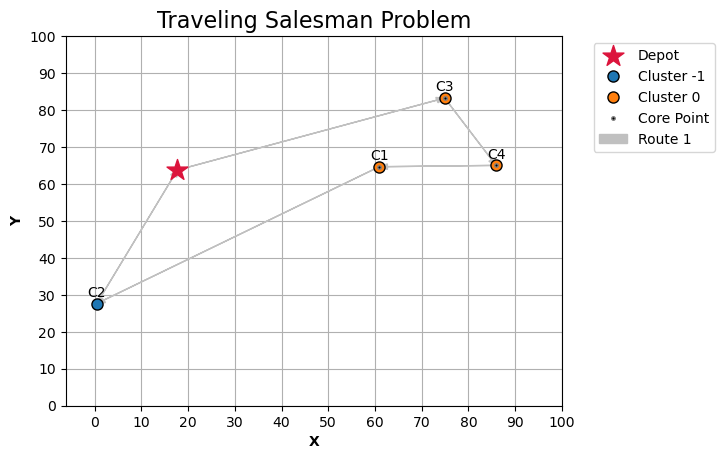

File saved successfully!


In [22]:
###############################################################################
# Generate random instances - settings
###############################################################################
# Assign string 'TSP' or 'CVRP' to the following variable to define the optimization problem
optimization_problem = 'TSP'

# Get the name of the folder and the file name
if (optimization_problem == 'TSP'):
    folder = '01_TSP'
    file_name = 'tsp_instances_d.xlsx'
elif (optimization_problem == 'CVRP'):
    folder = '02_CVRP'
    file_name = 'cvrp_instances_d.xlsx'
    capacity_min = 12
    capacity_max = 12
    demand_min = 1
    demand_max = 5

num_customers_list = [5]#, 6, 7, 8, 9, 10, 11, 12]#13, 14, 15] # All possible instance sizes (number of customers for an instance)
start_value = 1 # <- Der Wert hier wird als Instanz_id reingeschrieben, hab das drin weil ich immer mehrere Skripte Parallel laufen lasse, da können nicht alle bei 0 starten
number_of_instances_per_size = 1 # Determines the number of instances that are generated for each instance size (number of customers)
prints = False # Show prints and interim results during generating

# Define the range for X and Y coordinates and create DataFrame to merge final instances
x_range = (0, 100)
y_range = (0, 100)
df_final = pd.DataFrame()
run_time = {}

###############################################################################
# START GENERAITING
###############################################################################
for num_customers in num_customers_list:
    instance_id = 100000 * num_customers * start_value # -> Random gesetzt, hauptsache es gibt bei Parallelisierung keine Überschneidung der Indizes
    start = time.time() # Start time count
    if (len(num_customers_list) > 1) or (number_of_instances_per_size > 1): prints = False # No prints for more than one instance

    for inumber in range(0, number_of_instances_per_size):
        ###############################################################################
        # Generate a random instance
        ###############################################################################

        # Generate instance depending on the optimization problem
        if (optimization_problem == 'TSP'):
            instance_df = generate_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=y_range)
        elif (optimization_problem == 'CVRP'):
            instance_df = generate_cvrp_instance(num_customers, x_range, y_range, demand_min, demand_max, capacity_min, capacity_max)

        # Add instance id as to each row as first column and update instance id for next iteration
        instance_df.insert(0, 'Instance ID', instance_id)
        instance_id += 1

        # Add number of customers as second feature
        instance_df.insert(1, 'Number Customers', num_customers)

        # Add 'X Depot' and 'Y Depot' columns with depot coordinates
        x_depot = instance_df.loc[0, 'X'] # X coordinate of depot
        y_depot = instance_df.loc[0, 'Y'] # Y coordinate of depot
        instance_df['X Depot'] = x_depot
        instance_df['Y Depot'] = y_depot

        if (prints == True): print('############### INSTANCE ###############'); display(instance_df)

        ###############################################################################
        # Add distance features
        ###############################################################################

        # Calculate the distance between the depot and each location
        instance_df['Depot Distance'] = np.sqrt((instance_df['X'] - x_depot) ** 2 + (instance_df['Y'] - y_depot) ** 2) # Euclidean distance

        # Calculate distances from each customer to all other customers (excluding depot) - customer distances matrix
        customer_distances = cdist(instance_df.iloc[1:][['X', 'Y']], instance_df.iloc[1:][['X', 'Y']], metric='euclidean')

        # Replace diagonal values with np.nan; otherwise the customer will be his own closest customer
        np.fill_diagonal(customer_distances, np.nan)

        # Create an array with indices of all customers and loop over each of them (excluding the depot)
        all_customers = np.arange(start=1, stop=num_customers+1)
        for i, customer in enumerate(all_customers): # i starts with zero, customer starts with one

            # Sort the distances for the current customer
            sorted_distances = np.sort(customer_distances[i])

            # Add columns for the distances to the closest, second closest, third closest, and fourth closest customers and add the respective values of the customer
            instance_df.loc[customer, 'Closest Customer Distance (CCD)'] = sorted_distances[0]
            instance_df.loc[customer, '2nd CCD'] = sorted_distances[1]
            instance_df.loc[customer, '3rd CCD'] = sorted_distances[2]
            instance_df.loc[customer, '4th CCD'] = sorted_distances[3]
            instance_df.loc[customer, '5th CCD'] = sorted_distances[4] if (num_customers >= 6) else 100000
            instance_df.loc[customer, '6th CCD'] = sorted_distances[5] if (num_customers >= 7) else 100000
            instance_df.loc[customer, '7th CCD'] = sorted_distances[6] if (num_customers >= 8) else 100000
            instance_df.loc[customer, '8th CCD'] = sorted_distances[7] if (num_customers >= 9) else 100000
            instance_df.loc[customer, '9th CCD'] = sorted_distances[8] if (num_customers >= 10) else 100000
            instance_df.loc[customer, '10th CCD'] = sorted_distances[9] if (num_customers >= 11) else 100000

        # Calculate the mean distance to other customers
        customer_distances = pd.DataFrame(customer_distances, index=all_customers, columns=all_customers)
        mean_distances = customer_distances.mean(axis=1, skipna=True) # Calculate mean for each row over all columns, ignoring the np.nan

        # Add the 'Mean distance to other customers' column to the DataFrame (We add a NaN value for the depot since it doesn't have a mean distance)
        instance_df['Mean Distance To Other Customers'] = [np.nan] + mean_distances.tolist()
        
        # Calculate for each customer the distance to centroid of all customrs (excluding the depot) and save it in a new column
        centroid_x = instance_df.loc[1:, 'X'].mean()
        centroid_y = instance_df.loc[1:, 'Y'].mean()
        instance_df['Gravity Center Distance'] = np.sqrt((instance_df.loc[1:, 'X'] - centroid_x) ** 2 + (instance_df.loc[1:, 'Y'] - centroid_y) ** 2)
        
        # Define columns for displaying the instance
        instance_features = ['Instance ID', 'Number Customers', 'X', 'Y', 'X Depot', 'Y Depot']
        if (optimization_problem == 'CVRP'): instance_features[4:4] = ['Vehicle Capacity', 'Demand', 'Total Demand'] # Insert these columns at location 4

        distance_features = ['Depot Distance', 'Closest Customer Distance (CCD)', '2nd CCD', '3rd CCD', '4th CCD', '5th CCD', '6th CCD', 
                            '7th CCD', '8th CCD', '9th CCD', '10th CCD', 'Mean Distance To Other Customers', 'Gravity Center Distance']
        
        if (prints == True):
            print('\n############### DISTANCE FEATURES ###############')
            print('Customer distances:'); display(customer_distances,  instance_df[instance_features[:7] + distance_features])

        ###############################################################################
        # Add cluster features
        ###############################################################################

        # Cluster customers (without depot)
        # Get X and Y coordinates of the customers (excluding the depot)
        X = instance_df[['X', 'Y']][1:]

        # Clustering the customers of the instance
        assignments, core_point_indices = fun_multi_dbscan(X=X, num_customers=num_customers, prints=prints)

        # Extract X and Y coordinates of depot and all customers (first two columns) as tuples and give it as input for plot_instance
        coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]

        # View clusters
        if (prints == True):
            print('\n############### CLUSTER CUSTOMERS ###############')
            plot_instance(coord=coord, sequence=None, total_costs=None, x_range=x_range, y_range=y_range, 
                          assignments=assignments, core_point_indices=core_point_indices, plot_sequence=False, optimization_problem=optimization_problem)
        
        # Define columns for displaying the instance
        cluster_features = ['Cluster', 'Core Point', 'Outlier', 'Number Clusters', 'Number Outliers', 'Cluster Size', 'X Centroid', 'Y Centroid', 'Centroid Distance', 
                            'Centroid Distance To Depot', 'Distance To Closest Other Cluster', 'Distance To Closest Other Centroid', 'Cluster Area', 'Cluster Density']
        if (optimization_problem == 'CVRP'): cluster_features += ['Cluster Demand', 'Cluster Demand Proportion']

        # Execute function for cluster features
        instance_df = fun_cluster_features(data=instance_df, assignments=assignments, core_point_indices=core_point_indices, 
                                           features=instance_features[2:6]+cluster_features, prints=prints)

        ###############################################################################
        # Add statistics as features
        ###############################################################################

        # Extract X and Y values of the customers, excluding the first row (depot)
        x_customers = instance_df['X'].iloc[1:]
        y_customers = instance_df['Y'].iloc[1:]

        # Compute statistics for X and Y coordinates of the customers and add each of them as a column
        for statistic in [np.mean, np.std, np.max, np.min]:
            instance_df['X ' + statistic.__name__.capitalize()] = statistic(x_customers)
            instance_df['Y ' + statistic.__name__.capitalize()] = statistic(y_customers)
        
        # Calculate the correlation between X and Y of the customers as well as the skewness for X and Y and add statistics to each row as a column
        instance_df['Correlation'] = np.corrcoef(x_customers, y_customers)[0, 1] # Select first row and second column of correlation matrix
        instance_df['Skewness X'] = skew(x_customers)
        instance_df['Skewness Y'] = skew(y_customers)

        # Define columns for displaying the instance
        statistical_features = ['X Mean', 'Y Mean', 'X Std', 'Y Std', 'X Max', 'Y Max', 'X Min', 'Y Min', 'Correlation', 'Skewness X', 'Skewness Y']

        if (prints == True): print('\n############### STATISTICAL FEATURES ###############'); display(instance_df[instance_features + statistical_features])

        ###############################################################################
        # Solve instance and plot optimal solution
        ###############################################################################

        if (optimization_problem == 'TSP'):
            # Use X and Y coordinates of the depot and all customers to solve the instance and receive sequence (optimal tour) and total costs as output
            sequence, total_costs = solve_tsp(coord)

        elif (optimization_problem == 'CVRP'):
            # Get the demands and the capacity
            demands = list(instance_df['Demand'])
            capacity = list(instance_df['Vehicle Capacity'])[0]
            
            # Use X and Y coordinates of the depot and all customers as well as demands and capacity to solve the instance and receive sequence (optimal tour) and total costs as output
            sequence, total_costs = solve_cvrp(coord, demands, capacity)

        # Plot instance with optimal tour
        if (prints == True):
            print('\n############### SOLVE INSTANCE ###############')
            plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
                          plot_sequence=True, print_sequence=True, optimization_problem=optimization_problem)
        #break
        ###############################################################################
        # Calculate cost savings (just skip customer without solving the instance again)
        ###############################################################################
        
        # Create dictionary to store the results and iterate over each customer
        all_savings = {}
        for i in all_customers:
            # Determine origin; iterate through all trip-tuples with (origin, destination)
            for arc in sequence:
                # When a trip has customer i as destination (arc[1]), the origin of that trip an node before is arc[0]
                if (arc[1] == i): origin = arc[0]
            
            # Determine node_after; iterate through all trip-tuples with (origin, destination)
            for arc in sequence:
                # When a trip has customer i as origin (arc[0]), the destination of that trip and node after is arc[1]
                if (arc[0] == i): destination = arc[1]
           
            # Determine cost savings (saved distance by skipping customer i)
            trip_a_to_b = distance(coord[origin], coord[i])
            trip_b_to_c = distance(coord[i], coord[destination])
            trip_a_to_c = distance(coord[origin], coord[destination])
            savings = trip_a_to_b + trip_b_to_c - trip_a_to_c
            if (prints == True):
                if (i == 1): print('\n############### FEATURE COST SAVINGS ###############'); print('Sequence of optimally solved instance:', sequence)
                print('  - Customer: {}\n      Node before: {}, Node after: {}'.format(i, origin, destination))
                print('      Savings: {} + {} - {} = {}'.format(trip_a_to_b, trip_b_to_c, trip_a_to_c, savings))

            # Save in dictionary
            all_savings[i] = savings
        
        # Add savings to the DataFrame
        instance_df['Savings'] = [np.nan] + list(all_savings.values()) # Add a dummy value for the depot

        ###############################################################################
        # Calculate total costs for all subsets
        ###############################################################################
        
        # Iterate over all customers to create all possible subsets
        list_of_all_subsets = []
        for customer in all_customers:
            subsets = itertools.combinations(all_customers, customer) # customer 1: create object with singletons; customer 2: pairs, customer 3: trios etc.

            # Append singletons/pairs/trios... to list_of_all_subsets
            for subset in subsets:
                list_of_all_subsets.append(subset)
        
        # Solve instance for all possible subsets and store the total costs in the dictionary subset_total_costs
        subset_total_costs = {}
        for subset in list_of_all_subsets:
            
            # Use the coordinates of the depot and select the rows that contain the customers of the subset
            coordinates = [(instance_df['X'][0], instance_df['Y'][0])] + [(instance_df['X'][i], instance_df['Y'][i]) for i in subset]
            
            # Use these coordinates as input for the solving functions to get the costs of the optimal tour for the subset and store the result in the dictionary
            if (optimization_problem == 'TSP'):
                sub_sequence, sub_total_costs = solve_tsp(coordinates)
            
            elif (optimization_problem == 'CVRP'):
                demands = [0] + [instance_df['Demand'][i] for i in subset]
                sub_sequence, sub_total_costs = solve_cvrp(coordinates, demands, capacity)
            
            subset_total_costs[subset] = sub_total_costs
        
        if (prints == True):
            print('\n############### TOTAL COSTS OF ALL SUBSETS ###############')
            print('Every third element of subset_total_costs:'); display([{key: subset_total_costs[key]} for key in list(subset_total_costs.keys())[::3]])

        ###############################################################################
        # Calculate marginal costs (solve instance without customer)
        ###############################################################################

        # Initialize an empty list to store the marginal costs
        all_marginal_costs = []

        # Iterate over all customers to get the costs of the subset without the customer and compute the marginal costs
        for i in all_customers:
            set_without_customer = set(all_customers) - set([i])
            costs_without_customer = subset_total_costs[tuple(set_without_customer)]
            marginal_costs = total_costs - costs_without_customer

            if (prints == True):
                if (i == 1): print('\n############### FEATURE MARGINAL COSTS ###############')
                print('  - Customer {}\n      Set without customer: {}\n      Costs without customer: {}'.format(i, set_without_customer, costs_without_customer))
                print('      Marginal costs: {} - {} = {}'.format(total_costs, costs_without_customer, marginal_costs))

            # Append the marginal cost to the list
            all_marginal_costs.append(marginal_costs)
        
        # Add the marginal costs to the DataFrame and also a column for total costs
        instance_df['Marginal Costs'] = [np.nan] + all_marginal_costs # Add a dummy value for the depot
        instance_df['Total Costs'] = total_costs
        
        ###############################################################################
        # Calculate Shapley values
        ###############################################################################

        # Calculate Shapley value for each customer
        shapley_values = [0] # Zero for depot
        for i in all_customers:
            shapley_value = fun_shapley_value(player_index=i, characteristic_function=subset_total_costs, prints=prints)
            shapley_values.append(shapley_value)
        
        # Add Shapley values to the DataFrame
        instance_df['Shapley Value'] = shapley_values

        # Define columns for displaying the instance
        cost_features = ['Savings', 'Total Costs', 'Marginal Costs', 'Shapley Value']
        
        if (prints == True): display(instance_df[instance_features + cost_features])

        ###############################################################################
        # Add ratio features
        ###############################################################################

        # Define features for which the ratio should be computed
        ratio_features = ['X', 'Y', 'Depot Distance', 'Closest Customer Distance (CCD)', '2nd CCD', '3rd CCD', '4th CCD', '5th CCD', '6th CCD', '7th CCD', '8th CCD', 
                          '9th CCD', '10th CCD', 'Mean Distance To Other Customers', 'Gravity Center Distance', 'Centroid Distance', 'Centroid Distance To Depot', 
                          'Distance To Closest Other Cluster', 'Distance To Closest Other Centroid', 'Cluster Area', 'Cluster Density', 'Savings', 'Marginal Costs']

        if (optimization_problem == 'CVRP'): ratio_features += ['Demand', 'Cluster Demand', 'Cluster Demand Proportion']

        # Compute mean of all ratio_features (without the depot) and divide their values by mean to obtain ratio column which is inserted before the Shapley value
        for feature in ratio_features:
            mean = np.mean(instance_df.loc[1:, feature])
            ratio = instance_df.loc[1:, feature] / mean
            instance_df.insert(loc=len(instance_df.columns) - 1, column=feature + str(' Ratio'), value=ratio)
        
        if (prints == True):
            print('\n############### RATIO FEATURES ###############')
            print('No ratio features:\n', np.sort(list(set(instance_df.columns) - set(ratio_features) - set([i + str(' Ratio') for i in ratio_features]))))
            display(instance_df[[i + str(' Ratio') for i in ratio_features]])

        # Drop depot row and reset index
        instance_df.drop(index=0, inplace=True)
        instance_df.reset_index(drop=True)

        # Merge instances
        df_final = pd.concat([df_final, instance_df], ignore_index=True)

    # Stop time count for instance size and make print to show progress during generation
    run_time[num_customers] = time.time() - start
    if (num_customers_list[-1] > 10): print('- Instance size {} completed! Run time: {}'.format(num_customers, 
                                                                                                fun_convert_time(seconds=run_time[num_customers])))

    # View final instance when there was only one generated per instance size
    if (len(num_customers_list) == 1) and (number_of_instances_per_size == 1):
        print('\n############### FINAL INSTANCE ###############'); display(instance_df)
        plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
                      assignments=assignments, core_point_indices=core_point_indices, plot_sequence=True, print_sequence=True, optimization_problem=optimization_problem)

    # Else view run times and final DataFrame with merged instances
    elif (instance_id == (100000 * num_customers_list[-1] * start_value) + number_of_instances_per_size):
        print('-> Total run time: ', fun_convert_time(seconds=sum(run_time.values())))
        display({'Instance size: {} run time'.format(key): fun_convert_time(seconds=value) for key, value in run_time.items()})
        display(df_final)

# Save file
fun_save_file(data=df_final, subfolder_path='..\\..\\01_data\\' + folder, name=file_name)

In [ ]:
import sys
sys.exit()

**View run time of data generation per instance size**

In [ ]:
run_time

{5: 0.8422040939331055}

In [ ]:
# Function to plot the run time for each instance size
def plot_run_time(dictionary, values, title, name):

    # Adjust y-axis to show values in minutes/hours/days depending on the highest value
    max_value = max(values)
    if (max_value < 3600):
        max_tick = 60
        unit = 'minutes'
    elif (max_value < 86400):
        max_tick = 3600
        unit = 'hours'
    else:
        max_tick = max_value = 86400
        unit = 'days'

    # Create plot
    plt.figure(figsize=(10, 4))
    plt.plot([value / max_tick for value in values], color='b')
    plt.xticks(ticks=range(len(dictionary)), labels=dictionary.keys())
    plt.xlabel('Number of customers n (instance size)', size=12)
    plt.ylabel('Computation time in {}'.format(unit), size=12)
    plt.title(title, size=16)
    plt.grid()

    # Add annotations to show exact values
    for i, value in enumerate(values):
        plt.annotate(text=fun_convert_time(seconds=value), xy=(i, value/max_tick), textcoords='offset points', xytext=(2, 2), ha='center')
    
    # Save image as png
    plt.savefig('01_grafics\\' + name, bbox_inches='tight')
    plt.show()

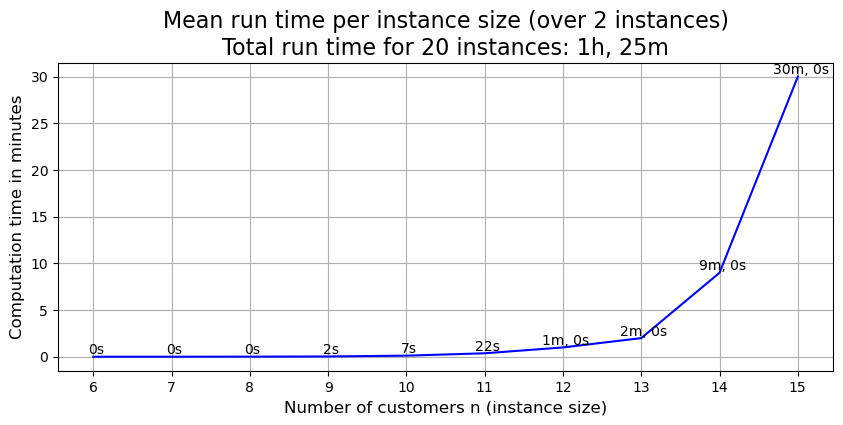

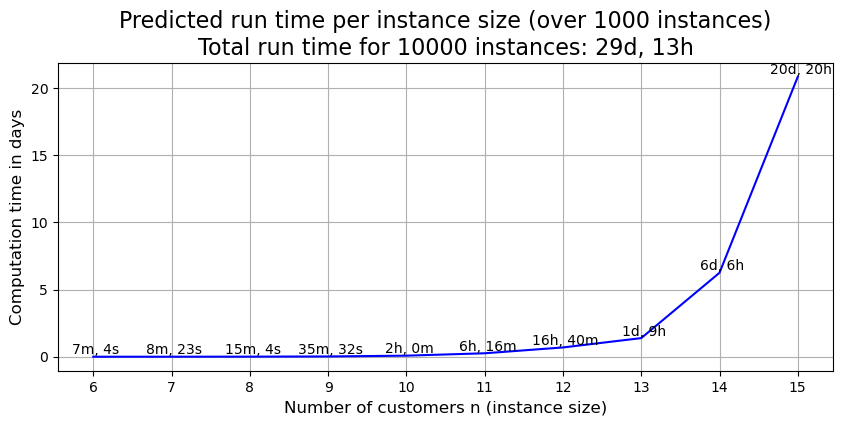

In [ ]:
# Function to create a plot with true and approximated run time for a number of instances per size
def fun_run_time_plots(dictionary, number_of_instances_per_size, multiplicator = 1, view_dict=True):
    # View dictionary values
    if (view_dict == True): display(dictionary)
    
    # Compute mean values
    mean_values = [value / number_of_instances_per_size for value in dictionary.values()]

    # Compute total run time and create title as well as image name for output plot
    total_run_time = fun_convert_time(seconds=np.sum(list(dictionary.values())))
    num_intances = len(dictionary.keys()) * number_of_instances_per_size
    title = str('Mean run time per instance size (over {} instances)\nTotal run time for {} instances: {}'.format(number_of_instances_per_size, 
                                                                                                                  num_intances, total_run_time))
    name = 'data_generation_run_time.png'

    # Use plot function to create plot
    plot_run_time(dictionary=dictionary, values=mean_values, title=title, name=name)

    # PREDICTION
    # Compute mean values in minutes (alternatively compute prediction with multiplicator value)
    new_number_of_instances_per_size = number_of_instances_per_size * multiplicator
    pred_dictionary = {key: value * multiplicator for key, value in dictionary.items()}
    
    # Compute total run time
    total_run_time = fun_convert_time(seconds=np.sum(list(pred_dictionary.values())))
    num_intances = len(pred_dictionary.keys()) * new_number_of_instances_per_size
    title = str('Predicted run time per instance size (over {} instances)\nTotal run time for {} instances: {}'.format(new_number_of_instances_per_size, 
                                                                                                                       num_intances, total_run_time))
    name = 'data_generation_run_time_approximation.png'

    # Use plot function to create plot
    plot_run_time(dictionary=pred_dictionary, values=pred_dictionary.values(), title=title, name=name)

# Save first run time dictionary
number_of_instances_per_size = 2
run_time_default = {6: 0.8495495319366455,
                    7: 1.0066370964050293,
                    8: 1.8085837364196777,
                    9: 4.264423847198486,
                    10: 14.435518741607666,
                    11: 45.12285137176514,
                    12: 120.0967059135437,
                    13: 240,
                    14: 1080,
                    15: 3600}

# Execute function to create and save plots
fun_run_time_plots(dictionary=run_time_default, number_of_instances_per_size=number_of_instances_per_size, multiplicator=500, view_dict=False)